In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [3]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [4]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


In [5]:
time_values = ds.time.values

Extract time values and units

In [6]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [7]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [8]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [9]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [10]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [11]:
ds = ds.drop_vars('time_index')

In [12]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [14]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [13]:
# Set time as the index
ds = ds.set_index(time='time')

In [15]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [16]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [17]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [18]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [19]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [20]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [21]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [22]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [23]:
df_flat.head(10)

,time,lat,lon,precipitation
0,1949-01-01,49.760941,-125.625,NaN
1,1949-01-01,49.760941,-125.000,NaN
2,1949-01-01,49.760941,-124.375,NaN
3,1949-01-01,49.760941,-123.750,NaN
4,1949-01-01,49.760941,-123.125,NaN
5,1949-01-01,49.760941,-122.500,NaN
6,1949-01-01,49.760941,-121.875,NaN
7,1949-01-01,49.760941,-121.250,NaN
8,1949-01-01,49.760941,-120.625,NaN
9,1949-01-01,49.760941,-120.000,NaN


Handle missing value in data

In [24]:
df_flat['precipitation'].fillna(0, inplace=True)

Check duplicated rows

In [25]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


Get ranges

In [26]:
min_date = df_flat['time'].min()
max_date = df_flat['time'].max()

print(f"The dataset covers from {min_date} to {max_date}.")

The dataset covers from 1949-01-01 00:00:00 to 1994-12-31 00:00:00.


In [27]:
# latitude
min_lat = df_flat['lat'].min()
max_lat = df_flat['lat'].max()

# longitude
min_lon = df_flat['lon'].min()
max_lon = df_flat['lon'].max()

print(f"The latitude range of the dataset is from {min_lat} to {max_lat}.")
print(f"The longitude range of the dataset is from {min_lon} to {max_lon}.")

The latitude range of the dataset is from 42.142059326171875 to 49.76094055175781.
The longitude range of the dataset is from -125.625 to -116.25.


Feature engineering

In [28]:
df_flat['month'] = df_flat['time'].dt.month
df_flat['year'] = df_flat['time'].dt.year

Temporal Features

In [29]:
df_flat['day_of_year'] = df_flat['time'].dt.dayofyear
df_flat['week_of_year'] = df_flat['time'].dt.isocalendar().week
df_flat['day_of_week'] = df_flat['time'].dt.dayofweek

In [30]:
df_flat.size

41128848

In [31]:
df_flat.head(10)

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
0,1949-01-01,49.760941,-125.625,0.0,1,1949,1,53,5
1,1949-01-01,49.760941,-125.000,0.0,1,1949,1,53,5
2,1949-01-01,49.760941,-124.375,0.0,1,1949,1,53,5
3,1949-01-01,49.760941,-123.750,0.0,1,1949,1,53,5
4,1949-01-01,49.760941,-123.125,0.0,1,1949,1,53,5
5,1949-01-01,49.760941,-122.500,0.0,1,1949,1,53,5
6,1949-01-01,49.760941,-121.875,0.0,1,1949,1,53,5
7,1949-01-01,49.760941,-121.250,0.0,1,1949,1,53,5
8,1949-01-01,49.760941,-120.625,0.0,1,1949,1,53,5
9,1949-01-01,49.760941,-120.000,0.0,1,1949,1,53,5


In [32]:
# df_flat.to_csv('precipitation_data.csv', index=False)

In [33]:
grouped_by_area = df_flat.groupby(['lat', 'lon'])

In [34]:
average_precipitation_per_area = grouped_by_area['precipitation'].mean().reset_index()

In [35]:
total_precipitation_per_area = grouped_by_area['precipitation'].sum().reset_index()

In [36]:
df_flat['precipitation'].unique()

array([  0. ,   2. ,   3.7, ..., 122.1, 156.6, 144.2], dtype=float32)

Fliter out Non zero

In [37]:
len(df_flat)

4569872

In [38]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [39]:
non_zero_precipitation_count

1329879

In [40]:
df_non_zero = df_flat[df_flat['precipitation'] > 0.0]

In [41]:
len(df_non_zero)

1329879

Visualization

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

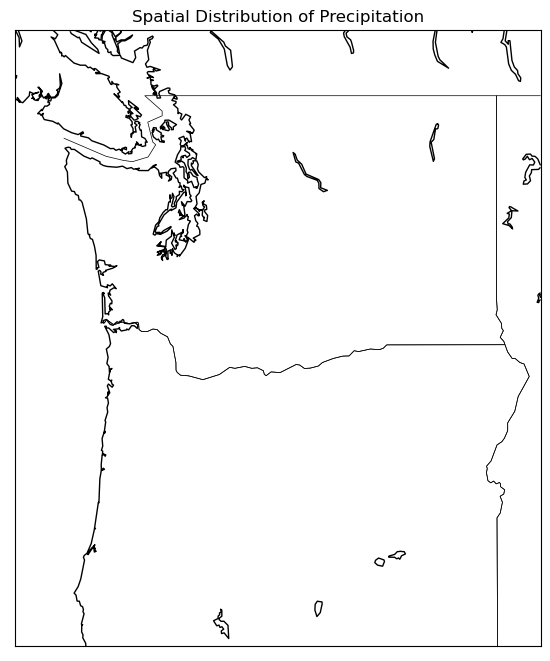

In [43]:
# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

plt.title('Spatial Distribution of Precipitation')
plt.show()

In [44]:
def filter_data(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.
    
    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box
    
    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[(df['precipitation'] > 0) & 
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) & 
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [45]:
def filter_data_within_range(df, central_lat, central_lon, lat_range, lon_range):
    """
    Selects data within a specified range around a central latitude and longitude.

    Parameters:
    - df: pandas DataFrame to filter.
    - central_lat: Central latitude of the target area.
    - central_lon: Central longitude of the target area.
    - lat_range: Latitude range (extent) around the central latitude.
    - lon_range: Longitude range (extent) around the central longitude.

    Returns:
    - A pandas DataFrame containing only the data within the specified range.
    """
    min_lat = central_lat - lat_range / 2
    max_lat = central_lat + lat_range / 2
    min_lon = central_lon - lon_range / 2
    max_lon = central_lon + lon_range / 2

    filtered_df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
                     (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    return filtered_df

In [46]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [47]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -123.125 to -122.5
Data points latitude range: 45.951499938964844 to 46.42768096923828


In [48]:
def calculate_average_precipitation(df):
    """
    Groups the DataFrame by latitude and longitude and calculates the mean precipitation.
    
    Parameters:
    - df: pandas DataFrame with the filtered dataset
    
    Returns:
    - A pandas DataFrame with the mean precipitation for each group
    """
    return df.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

In [49]:
def plot_precipitation_heatmap(grouped_data, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data.
    
    Parameters:
    - grouped_data: pandas DataFrame with average precipitation data
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1, 
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')
    else:
        print("No data available to plot.")

    print(f"Data points longitude range: {grouped_data['lon'].min()} to {grouped_data['lon'].max()}")
    print(f"Data points latitude range: {grouped_data['lat'].min()} to {grouped_data['lat'].max()}")

    if extent:
        print(f"Setting extent to: {extent}")
        # Set the extent using the set_extent method
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        # ax.set_xlim(extent[0], extent[1])
        # ax.set_ylim(extent[2], extent[3])
    else:
        print("Auto-adjusting extent based on data.")
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Data points longitude range: -124.375 to -116.25
Data points latitude range: 42.142059326171875 to 48.80857849121094
Auto-adjusting extent based on data.


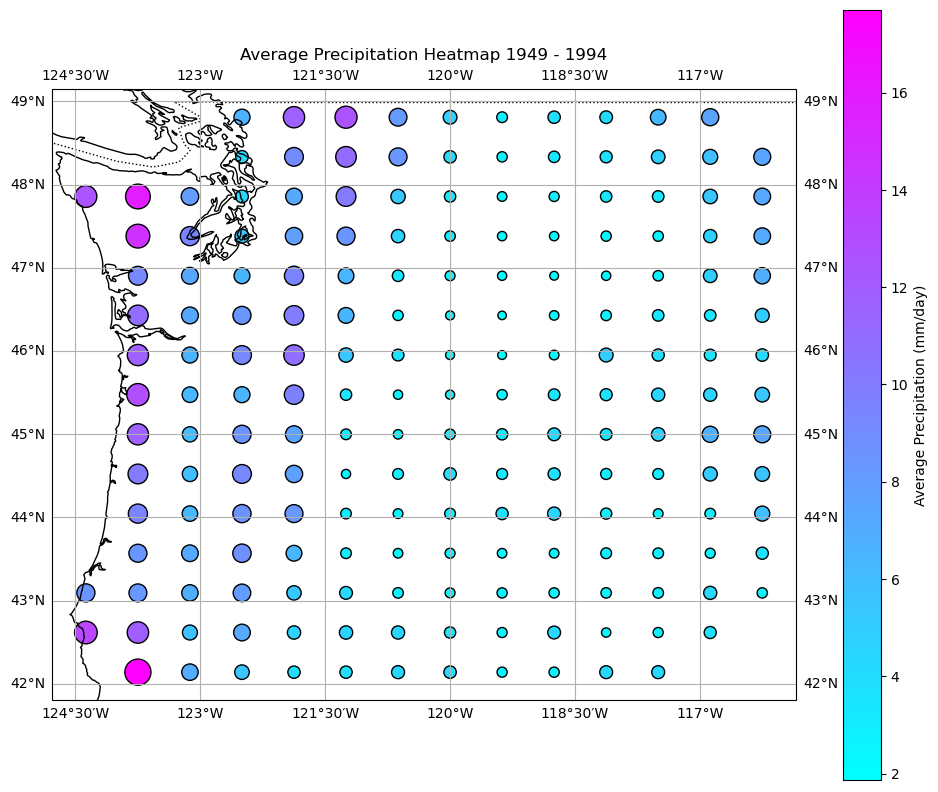

In [50]:
# Group by latitude and longitude to calculate the mean precipitation
grouped_data = calculate_average_precipitation(df_non_zero)

plot_title = 'Average Precipitation Heatmap 1949 - 1994'
plot_precipitation_heatmap(grouped_data, plot_title)

In [51]:
# The bounds of the area to zoom into
min_lon, max_lon = -123, -121
min_lat, max_lat = 46, 48

In [52]:
# Filter data within the specified area.
filtered_df = filter_data(df_non_zero, min_lon, max_lon, min_lat, max_lat)

# Calculate the average precipitation
average_precip = calculate_average_precipitation(filtered_df)

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768096923828 to 47.85622024536133
Setting extent to: (-123, -121, 46, 48)


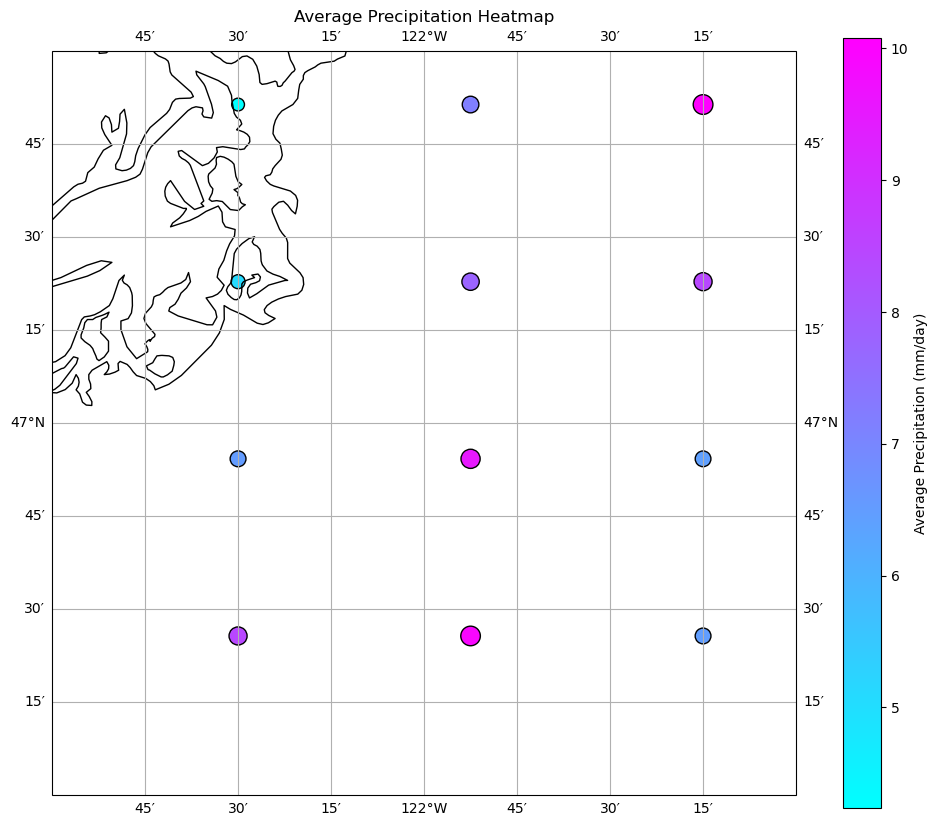

In [53]:
# Plot the results with a specified extent
plot_title = 'Average Precipitation Heatmap'
plot_precipitation_heatmap(average_precip, plot_title, extent=(min_lon, max_lon, min_lat, max_lat))

In [54]:
# df_filtered = df_non_zero

# # Group by latitude and longitude to calculate the mean precipitation
# grouped = df_filtered.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

# # Create a figure with an projection
# fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# if not grouped.empty:
#     # Scatter plot for average precipitation
#     sc = ax.scatter(grouped['lon'], grouped['lat'], c=grouped['precipitation'],
#                     cmap='cool', s=150, edgecolor='black', linewidth=1,
#                     transform=ccrs.PlateCarree())  # Ensure the transform is correct
#     plt.colorbar(sc, label='Average Precipitation (mm/day)')
# else:
#     print("No non-zero precipitation data available to plot.")

# # Set the geographic extent to encompass all points or focus on a particular region
# # ax.set_extent([min longitude, max longitude, min latitude, max latitude], crs=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.title('Average Precipitation Heatmap 1949 - 1994')
# plt.show()

Plot specific area

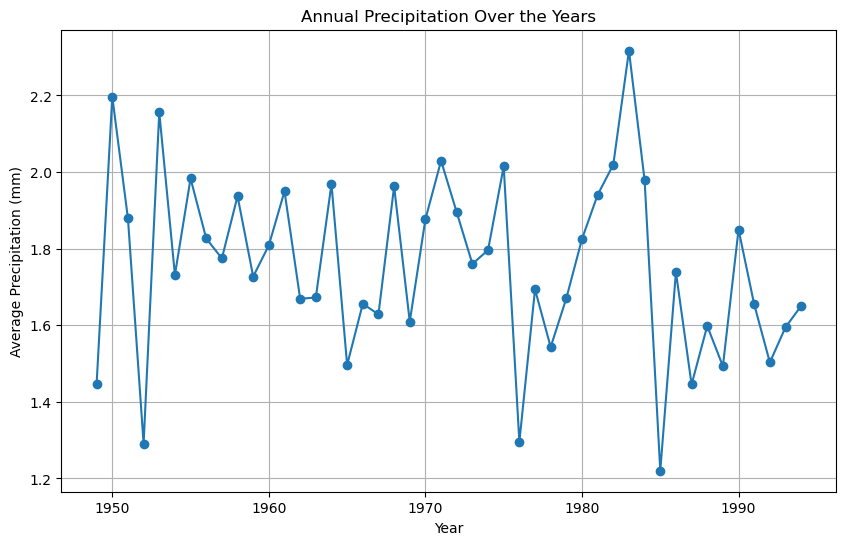

In [55]:
average_precipitation_df = df_flat.groupby('year')['precipitation'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_df['year'], average_precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Annual Precipitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.show()

In [56]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_flat, central_lat, central_lon, lat_range, lon_range)

In [57]:
selected_data

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
116,1949-01-01,46.427681,-123.125,4.600000,1,1949,1,53,5
117,1949-01-01,46.427681,-122.500,20.200001,1,1949,1,53,5
132,1949-01-01,45.951500,-123.125,20.600000,1,1949,1,53,5
133,1949-01-01,45.951500,-122.500,18.200001,1,1949,1,53,5
388,1949-01-02,46.427681,-123.125,3.300000,1,1949,2,53,6
...,...,...,...,...,...,...,...,...,...
4569461,1994-12-30,45.951500,-122.500,0.000000,12,1994,364,52,4
4569716,1994-12-31,46.427681,-123.125,0.000000,12,1994,365,52,5
4569717,1994-12-31,46.427681,-122.500,0.000000,12,1994,365,52,5
4569732,1994-12-31,45.951500,-123.125,0.000000,12,1994,365,52,5


In [58]:
# Group by year and calculate average precipitation
average_precipitation_per_year = selected_data.groupby('year')['precipitation'].mean().reset_index()

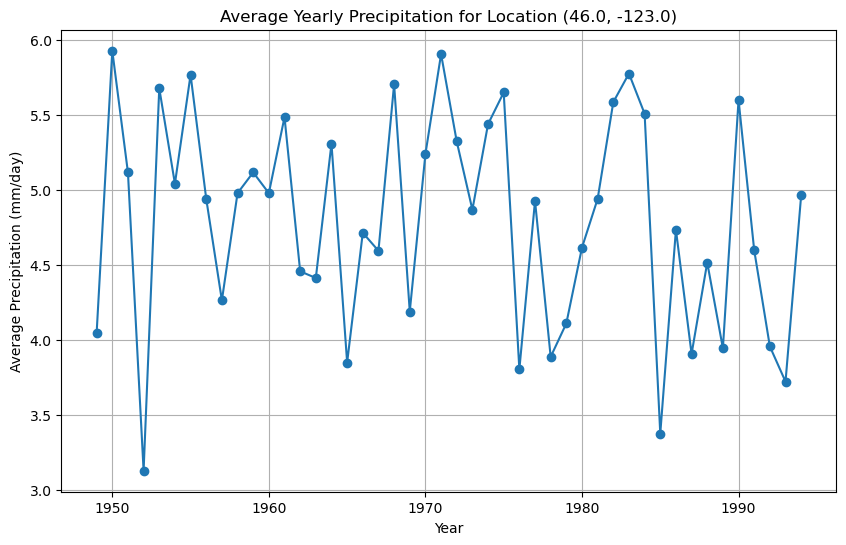

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_per_year['year'], average_precipitation_per_year['precipitation'], marker='o')
plt.title(f"Average Yearly Precipitation for Location ({central_lat}, {central_lon})")
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.show()

 zoom into the specific geographic zone

In [60]:
# Define the bounds of the area to zoom into
min_lon, max_lon = -117, -0
min_lat, max_lat = 43, 44

df_to_fliter = df_flat
# Filter the data for the specified zone
zone_data = df_to_fliter[(df_to_fliter['lon'] >= min_lon) & (df_to_fliter['lon'] <= max_lon) &
               (df_to_fliter['lat'] >= min_lat) & (df_to_fliter['lat'] <= max_lat)]

In [61]:
annual_precip = zone_data.groupby('year')['precipitation'].mean().reset_index()

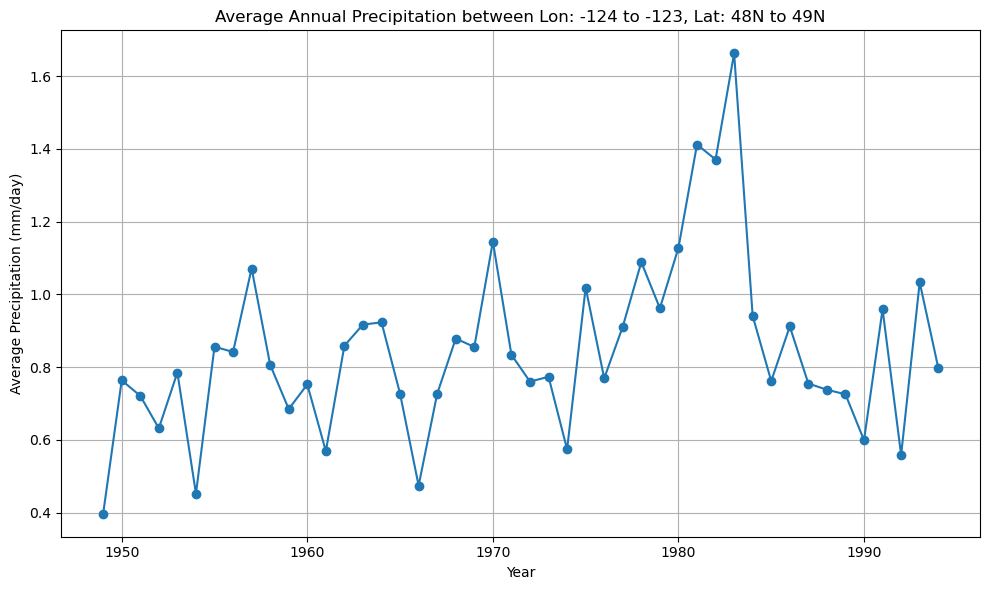

In [62]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_precip['year'], annual_precip['precipitation'], marker='o')
plt.title('Average Annual Precipitation between Lon: -124 to -123, Lat: 48N to 49N')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.tight_layout()
plt.show()

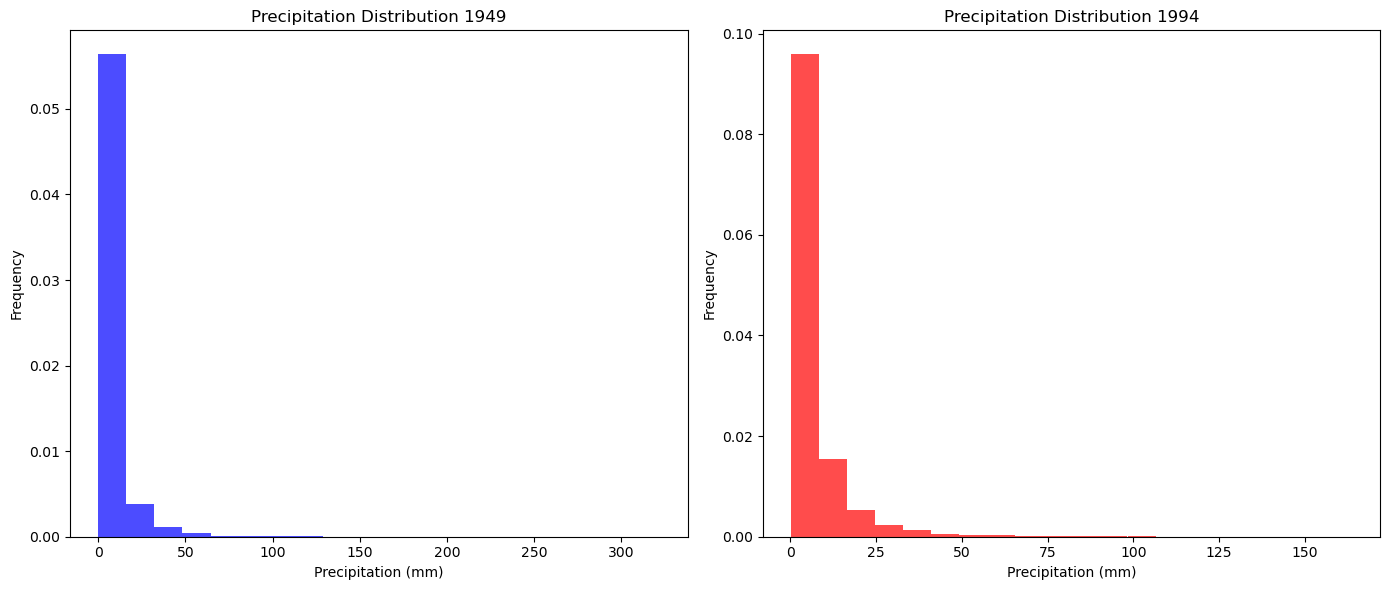

In [63]:
data_year1 = df_non_zero[df_non_zero['year'] == 1949]['precipitation']
data_year2 = df_non_zero[df_non_zero['year'] == 1994]['precipitation']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(data_year1, bins=20, density=True, color='blue', alpha=0.7)
ax[0].set_title('Precipitation Distribution 1949')
ax[0].set_xlabel('Precipitation (mm)')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_year2, bins=20, density=True, color='red', alpha=0.7)
ax[1].set_title('Precipitation Distribution 1994')
ax[1].set_xlabel('Precipitation (mm)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

 Boxplots for Comparing Precipitation Across Different Years or Locations

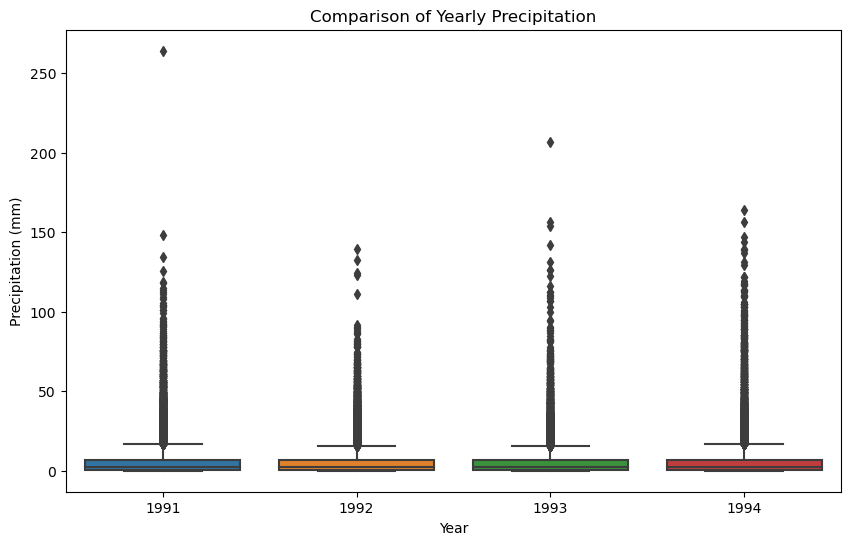

In [64]:
import seaborn as sns

# Prepare data for multiple years or locations
boxplot_data = df_non_zero[df_non_zero['year'].isin([1991, 1992, 1993, 1994])]

plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='precipitation', data=boxplot_data)
plt.title('Comparison of Yearly Precipitation')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.show()

In [65]:
df_flat

,time,lat,lon,precipitation,month,year,day_of_year,week_of_year,day_of_week
0,1949-01-01,49.760941,-125.625,0.000000,1,1949,1,53,5
1,1949-01-01,49.760941,-125.000,0.000000,1,1949,1,53,5
2,1949-01-01,49.760941,-124.375,0.000000,1,1949,1,53,5
3,1949-01-01,49.760941,-123.750,0.000000,1,1949,1,53,5
4,1949-01-01,49.760941,-123.125,0.000000,1,1949,1,53,5
...,...,...,...,...,...,...,...,...,...
4569867,1994-12-31,42.142059,-118.750,23.900000,12,1994,365,52,5
4569868,1994-12-31,42.142059,-118.125,25.800001,12,1994,365,52,5
4569869,1994-12-31,42.142059,-117.500,7.400000,12,1994,365,52,5
4569870,1994-12-31,42.142059,-116.875,0.000000,12,1994,365,52,5


In [66]:
df_time_series = df_flat

In [67]:
df_time_series = df_flat.copy()

In [68]:
df_time_series['precipitation'] = df_time_series['precipitation'].fillna(0)

In [69]:
df_time_series.set_index(['time', 'lat', 'lon'], inplace=True)

In [70]:
df_time_series

precipitation  month  year  day_of_year  \
time       lat       lon                                                 
1949-01-01 49.760941 -125.625       0.000000      1  1949            1   
                     -125.000       0.000000      1  1949            1   
                     -124.375       0.000000      1  1949            1   
                     -123.750       0.000000      1  1949            1   
                     -123.125       0.000000      1  1949            1   
...                                      ...    ...   ...          ...   
1994-12-31 42.142059 -118.750      23.900000     12  1994          365   
                     -118.125      25.800001     12  1994          365   
                     -117.500       7.400000     12  1994          365   
                     -116.875       0.000000     12  1994          365   
                     -116.250       0.000000     12  1994          365   

                               week_of_year  day_of_week  
time       lat       lon                                  
1949-01-01 49.760941 -125.625            53            5  
                     -125.000            53            5  
                     -124.375            53            5  
                     -123.750            53            5  
                     -123.125            53            5  
...                                     ...          ...  
1994-12-31 42.142059 -118.750            52            5  
                     -118.125            52            5  
                     -117.500            52            5  
                     -116.875            52            5  
                     -116.250            52            5  

[4569872 rows x 6 columns]

In [71]:
location_dataframes = {}
for (lat, lon), group in df_flat.groupby(['lat', 'lon']):
    location_dataframes[(lat, lon)] = group

In [72]:
def train_model(data):
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(data['time'], data['precipitation'])
    return model

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Calculate the sum of squared distances (SSD) for a range of number of clusters
ssd = []
coords = df_flat[['lat', 'lon']].drop_duplicates().values 
K = range(1, 50)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Example using K-Means to cluster geographic locations
coords = df_flat[['lat', 'lon']].drop_duplicates().values  # unique coordinate pairs
kmeans = KMeans(n_clusters=100, random_state=42)  # adjust clusters based on specific needs
clusters = kmeans.fit_predict(coords)

# Map cluster labels back to the original data
cluster_map = {tuple(coord): cluster for coord, cluster in zip(coords, clusters)}
df_flat['location_cluster'] = df_flat.apply(lambda row: cluster_map[(row['lat'], row['lon'])], axis=1)

Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [74]:
df_time_series 

precipitation  month  year  day_of_year  \
time       lat       lon                                                 
1949-01-01 49.760941 -125.625       0.000000      1  1949            1   
                     -125.000       0.000000      1  1949            1   
                     -124.375       0.000000      1  1949            1   
                     -123.750       0.000000      1  1949            1   
                     -123.125       0.000000      1  1949            1   
...                                      ...    ...   ...          ...   
1994-12-31 42.142059 -118.750      23.900000     12  1994          365   
                     -118.125      25.800001     12  1994          365   
                     -117.500       7.400000     12  1994          365   
                     -116.875       0.000000     12  1994          365   
                     -116.250       0.000000     12  1994          365   

                               week_of_year  day_of_week  
time       lat       lon                                  
1949-01-01 49.760941 -125.625            53            5  
                     -125.000            53            5  
                     -124.375            53            5  
                     -123.750            53            5  
                     -123.125            53            5  
...                                     ...          ...  
1994-12-31 42.142059 -118.750            52            5  
                     -118.125            52            5  
                     -117.500            52            5  
                     -116.875            52            5  
                     -116.250            52            5  

[4569872 rows x 6 columns]

In [75]:
# Creating dummy variables for each location
df_time_series = df_flat
df_time_series.set_index('time', inplace=True)
df_time_series = pd.get_dummies(df_flat, columns=['lat', 'lon', 'month'])

# Prepare features and target
X = df_time_series.drop(['precipitation', 'year'], axis=1)
y = df_time_series['precipitation']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [79]:
scaler = StandardScaler()
pca = PCA(n_components=0.95)  # Retain 95% of the variance
forest = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

pipeline = make_pipeline(scaler, pca, forest)


In [80]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=50,
                                       random_state=42))])

In [82]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 28.42413693924082


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df_flat is loaded with 'lat', 'lon', 'month', 'precipitation'
# Cyclical encoding for month
df_flat['month_sin'] = np.sin((df_flat['month']-1)*(2.*np.pi/12))
df_flat['month_cos'] = np.cos((df_flat['month']-1)*(2.*np.pi/12))

# Spatial binning (example: k-means clustering on lat-lon, assume 'clusters' is the result)
df_flat['location_cluster'] = clusters

# Prepare features and target
X = df_flat[['location_cluster', 'month_sin', 'month_cos']]
y = df_flat['precipitation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Evaluate the model
y_pred = forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

In [ ]:
df_time_series = df_flat.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, cutoff=0.05):
    result = adfuller(series.dropna())  # dropna() to remove missing values that might affect the test
    p_value = result[1]
    return p_value < cutoff, p_value  # Returns True if the series is stationary

In [ ]:
# Assume df is prepared with 'time' as a datetime index
unique_locations = df_time_series [['lat', 'lon']].drop_duplicates().reset_index(drop=True)

# Dictionary to store stationarity results
stationarity_results = {}

for _, row in unique_locations.iterrows():
    lat, lon = row['lat'], row['lon']
    # Filter data for the specific location
    series = df_time_series [(df_time_series ['lat'] == lat) & (df_time_series ['lon'] == lon)]['precipitation']
    # Check stationarity
    is_stationary, p_value = check_stationarity(series)
    stationarity_results[(lat, lon)] = {'stationary': is_stationary, 'p_value': p_value}

In [ ]:
# Example to print out non-stationary locations
for location, result in stationarity_results.items():
    if not result['stationary']:
        print(f"Location {location} is not stationary; p-value: {result['p_value']}")

In [ ]:
def difference_series(series):
    return series.diff().dropna()  # Simple differencing

# Apply differencing where needed
for location, result in stationarity_results.items():
    if not result['stationary']:
        lat, lon = location
        df_time_series .loc[(df_time_series ['lat'] == lat) 
                            & (df_time_series ['lon'] == lon), 'precipitation'] = difference_series(df_time_series [(df_time_series ['lat'] == lat) 
                                                                                                                    & (df_time_series ['lon'] == lon)]['precipitation'])